In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi, ceil
from scipy.special import erfinv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randint
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt, log
from numpy.linalg import lstsq
import networkx as nx


warnings.filterwarnings("ignore")

In [2]:
def preprocessing(data, method):
    ts_train = []
    ts_valid = []
    ts_test = []
    ts_param = []
    flag_n = False
    flag_diff = False
    flag_dec = False
    if method is 'normalization':
        flag_n = True
    elif method is 'differencing':
        flag_diff = True
            
    for i in range(data.shape[1]):

        temp = list(data.iloc[6:][i].dropna())
        # print(temp)
        if len(temp) > 130:
            
            cut_off_1 = ceil(len(temp)*0.7)
            cut_off_2 = ceil(len(temp)*0.9)

            temp_train = temp[:cut_off_1]
            temp_val = temp[cut_off_1:cut_off_2]
            temp_test = temp[cut_off_2:]

            if flag_n is True:
                ts_param.append([np.mean(temp_train), np.std(temp_train), np.mean(temp_val), 
                np.std(temp_val), np.mean(temp_test), np.std(temp_test)])
                
                temp_train = (temp_train - np.mean(temp_train)) / np.std(temp_train)
                ts_train.append(temp_train)
                

                temp_val = (temp_val - np.mean(temp_val)) / np.std(temp_val)
                ts_valid.append(temp_val)

                temp_test = (temp_test - np.mean(temp_test)) / np.std(temp_test)
                ts_test.append(temp_test)
                

            elif flag_diff is True:

                temp_train_diff = [temp_train[i] - temp_train[i - 1] for i in range(1, len(temp_train))]
                temp_train_diff = [temp_train[0]] + temp_train_diff
                ts_train.append(temp_train_diff)

                temp_val_diff = [temp_val[i] - temp_val[i - 1] for i in range(1, len(temp_val))]
                temp_val_diff = [temp_val[0]] + temp_val_diff
                ts_valid.append(temp_val_diff)

                temp_test_diff = [temp_test[i] - temp_test[i - 1] for i in range(1, len(temp_test))]
                temp_test_diff = [temp_test[0]] + temp_test_diff
                ts_test.append(temp_test_diff)
                
    return ts_train, ts_valid, ts_test, ts_param

# ts_train, ts_valid, ts_test, ts_param = preprocessing(df_temp, method='normalization')

[*********************100%***********************]  5 of 5 completed


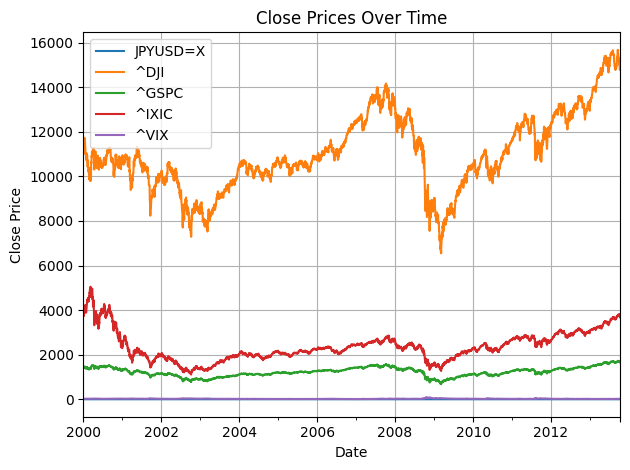

In [3]:
# Jupyter Code Block
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to fetch financial data
def fetch_financial_data(tickers, start_date='2000-01-01', end_date='2013-10-10'):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Close']

# List of tickers
# Replace 'TIPS_TICKER' with the actual ticker for the TIPS you are interested in
tickers = ["^GSPC", "^IXIC", "^DJI","JPYUSD=X", "^VIX"] # , "GBPUSD=X", "EURUSD=X",
data = fetch_financial_data(tickers)

# Data cleaning: fill NaN values using forward fill method
data_filled = data.fillna(method='ffill')
def fill_leading_nans_with_one(series):
    first_valid = series.first_valid_index()
    if first_valid is not None:
        series[:first_valid] = 1
    return series
# Ensure indexes match across the board
# data_filled = data_filled.dropna()

# Plot
for column in data_filled.columns:
    data_filled[column].plot(label=column)
plt.title("Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
cols = ['^GSPC'] + [col for col in data_filled if col != '^GSPC']
data_filled = data_filled[cols]
data_filled

In [4]:
cols = ['^GSPC'] + [col for col in data_filled if col != '^GSPC']
data_filled = data_filled[cols]
data_filled

,^GSPC,JPYUSD=X,^DJI,^IXIC,^VIX
Date,,,,,
2000-01-03,1455.219971,0.009834,11357.509766,4131.149902,24.209999
2000-01-04,1399.420044,0.009696,10997.929688,3901.689941,27.010000
2000-01-05,1402.109985,0.009607,11122.650391,3877.540039,26.410000
2000-01-06,1403.449951,0.009503,11253.259766,3727.129883,25.730000
2000-01-07,1441.469971,0.009494,11522.559570,3882.620117,21.719999
...,...,...,...,...,...
2013-10-03,1678.660034,0.010277,14996.480469,3774.340088,17.670000
2013-10-04,1690.500000,0.010282,15072.580078,3807.750000,16.740000
2013-10-07,1676.119995,0.010279,14936.240234,3770.379883,19.410000


In [5]:
class AutoregressiveTree:
    
    def __init__(self, p, u0=0, alpha_u=1, X=None):
        self._X = X  # Exogenous data
        
        erf_temp = np.zeros([7,1])
        for i in range(1,8):
            erf_temp[i-1] = erfinv((i/4) - 1)
        
        self._erf = erf_temp
        self._p = p
        self._alpha_W = p + 2

        self._u0 = u0
        self._alpha_u = alpha_u
        self.target = []
        self.exog = []
        self.test = {}
    #  calculate the sample mean of the data (could be a vector), maybe split into sample mean of each variable
    def sample_mean(self, data):
        # print(sum(data), len(data))
        return sum(np.asarray(data))/len(data)

    
    # calculate the scatter matrix around the mean uN
    # def scatter_matrix(self, data, uN_):
    def scatter_matrix(self, data, uN_):

        # assert data.shape[1] == p * (1 + no_exog_vars), 'Data dimensions do not match expected shape'
        # Assuming data has been preprocessed to include lags of y and X
        temp = data - uN_

        SN = 0
        for row in temp:
            row = row[:, np.newaxis]
            SN += row * row.T
        # print(len(SN),len(SN[0]))
        return SN
    # def WN_func(self, uN_, SN, W0, N):
    def WN_func(self, uN_, SN, W0, N):
        # assert SN.shape[0] == p * (1 + no_exog_vars), 'Scatter matrix dimensions do not match expected shape'
        temp = self._u0 - uN_

        # Assuming scatter matrix has been computed from preprocessed data
        temp = temp[:, np.newaxis]
        WN = W0 + SN + ((self._alpha_u * N) / (self._alpha_u + N)) * np.dot(temp, temp.T)
        return WN
    # Updates the matrix WN_d, calculates the within node covariance matrix 
    def WN_d_func(self, uN_d_, SN_d_, W0_, N_):
        temp = -uN_d_
        temp = temp[:, np.newaxis]
        WN_ = W0_ + SN_d_ + ((self._alpha_u * N_) / (self._alpha_u + N_)) * np.dot(temp, temp.T)
        return WN_
    # calculating the Maximum a posteriori arameters for the ar model
    def MAP_param(self, N, uN_, WN, q):
        ut = ((self._alpha_u * self._u0) + (N * uN_)) / (self._alpha_u + N)
        div = (self._alpha_W + N - (self._p + 1 + q))
        if div == 0:
            div = 0.00001
        Wt_inv = (1 / div) * WN
        return ut, Wt_inv

    def param(self, target, exog):
        # Construct the data matrix (X) using the provided lags
        self.test = {'tar' : target, 'exog' :exog}
        # data = []
        # for t, e in zip(target, np.asarray(exog).transpose(1, 0, 2)):
        #         data.append(np.concatenate([t, e.flatten()]))
        # y = np.array(data).T[0]
        reshaped_data = np.concatenate(exog, axis=1)
        data = np.hstack((target, reshaped_data))
        # Add intercept term (column of ones) to X
        X = np.hstack([np.ones((data.shape[0], 1)), data[:, 1:]])
        y = data[:,0]
        self.target, self.exog = y, data

        # Estimate coefficients using OLS
        coeffs, residuals, rank, s = lstsq(X, y, rcond=None)

        # Here, 'coeffs' contains the estimated parameters (betas, gammas, and the intercept term)
        # 'residuals' contains the sum of squared residuals

        # If residuals are empty (it happens when m <= n), calculate manually
        if residuals.size == 0:
            residuals = np.sum((y - X.dot(coeffs))**2)

        # The variance of the residuals can be an estimate for the variance of the error term
        var = residuals / len(y)

        # 'b' will be our coefficients (excluding the intercept) and 'm' will be the intercept.
        # b = coeffs[1:].reshape(-1, 1)
        m = [coeffs[0]]

        return var, coeffs[1:], m
    # scaling function using the gamma distribution
    def c_func(self, l, alpha):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= gamma((alpha + 1 - i) / 2)
        
        return c
    # probability density scaling function used
    def pds_func(self, N, W0, WN):
        pds = (pi**(-((self._p + 1) * N) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W + N) / self.c_func(self._p + 1, self._alpha_W)) * (det(W0)**(self._alpha_W / 2))*(det(WN)**(-(self._alpha_W + N) / 2))
        return pds
    # similiar to above just now with different params
    def pd_s_func(self, u0_, N_, W0_, WN_):
        pds = (pi**(-((self._p + 1) * N_) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N_))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W - 1 + N_) / self.c_func(self._p + 1, self._alpha_W - 1)) * (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2))
        return pds
    def mult_func(self, l, alpha, N):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= ((alpha + 1 + N - i)/(alpha + 1 - i))
        # print(c)
        return c

    def pds_func2(self, N, W0, WN, u0_, N_, W0_, WN_):

        pds = (det(W0)**(self._alpha_W / 2))*det(WN)**(-(self._alpha_W + N) / 2) / \
        (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2)) * \
        self.mult_func(self._p + 1,self._alpha_W, N)                                                                                                             

        return pds
    def pds_approx(self, N, W0, WN):

        likelihood_val = (self._alpha_u / (self._alpha_u + N))**((self._p + 1) / 2)
        likelihood_val *= (det(W0)**(self._alpha_W / 2))
        likelihood_val *= (det(WN)**(-(self._alpha_W + N) / 2))
        likelihood_val -= self._alpha_W/2 * log(N)
        return likelihood_val
    
    def LeafScore(self, data):
        N = len(data)
        self.target = data
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        # ut, Wt_inv = self.MAP_param(N, uN_, WN, 0)
        data_ = data[:-1]
        N_ = len(data_)
        uN_d_ = self.sample_mean(data_)
        SN_d_ = self.scatter_matrix(data_, uN_d_)
        u0_ = 0
        W0_ = inv(inv(W0))
        WN_d_ = self.WN_d_func(uN_d_, SN_d_, W0_, N_)

        if N > 20:
            # pds2 = self.pds_func2(N, W0, WN, u0_, N_, W0_, WN_d_)
            pds = self.pds_approx(N, W0, WN)
            pds_ = self.pds_approx(N_, W0_, WN_d_)
            pds2 = pds/pds_
        else:
            pds = self.pds_func(N, W0, WN)
            pds_ = self.pd_s_func(u0_, N_, W0_, WN_d_)
            pds2 =  pds/pds_
        
        return pds2
        
    # This will spplit a dataset into two froups based on the specific features. Then splits the data points into the left or right set
    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    def rest_split(self, index, value, train, exog, ex, var):
                # Initializations
        left, right = [], []
        left_e, right_e = [], []
        
        # Convert to DataFrame for easier operations
        train_df = pd.DataFrame(train)
        exog_dfs = [pd.DataFrame(ex) for ex in exog]

        # Split based on exogenous variable
        if ex == "y":
            # Split the specified variable in exog
            for i, row in exog_dfs[var].iterrows():
                if row[index] < value:
                    left_e.append(i)
                else:
                    right_e.append(i)
            if not left_e or not right_e:
                return None, None, None, None
            left_e_index = pd.Index(left_e)
            right_e_index = pd.Index(right_e)

            # Extract corresponding rows from other variables in exog and from train
            left_exog = [df.loc[left_e_index] for df in exog_dfs]
            right_exog = [df.loc[right_e_index] for df in exog_dfs]

            left = train_df.loc[left_e_index]
            right = train_df.loc[right_e_index]

        # Split based on training data
        else:
            for i, row in train_df.iterrows():
                if row[index] < value:
                    left.append(i)
                else:
                    right.append(i)
            if not left or not right:
                return None, None, None, None
            
            left_index = pd.Index(left)
            right_index = pd.Index(right)

            left = train_df.loc[left_index]
            right = train_df.loc[right_index]

            left_exog = [df.loc[left_index] for df in exog_dfs]
            right_exog = [df.loc[right_index] for df in exog_dfs]
        left = left.values.tolist()
        right = right.values.tolist()
        left_exog = [df.values.tolist() for df in left_exog]
        right_exog = [df.values.tolist() for df in right_exog]
        return left, right, left_exog, right_exog
    # itrates through the features and the values to det the best for splitting the dataset, calkculates the score for each split and choses the one with best improvement
    def get_split(self, train, train_exog):
        self.target, self.exog = train, train_exog
        b_index, b_value, b_groups, var = 999, 999, None, 'y'
        b_score = self.LeafScore(train)
        avg = np.mean(train, axis=0)[:-1]
        sigma = np.std(train, axis=0)[:-1]
        split_data = train, train_exog
        for index in range(len(avg)):
            for i in range(len(self._erf)):

                value = avg[index] + sigma[index] * self._erf[i]
                # groups = self.test_split(index, value, train)
                data = self.rest_split(index, value, train, train_exog,"n", 0)
                groups = data[0], data[1]
                if data is None or data[0] is None or data[1] is None:
                    # print("NONE TYPE")
                    continue
                new_score = 1
                for group in groups:
                    if len(group) > 1:
                        new_score *= self.LeafScore(group)
            
                        if new_score > b_score:
                            b_index, b_value, b_score, b_groups, var, split_data = index, value, new_score, groups, ("y"+str(index)), data
        j = 0
        bb_score = 1
        for ex in train_exog:
            # print(j)
            self.exog = ex
            avg = np.mean(ex, axis=0)
            min_e = np.min(ex, axis=0)
            max_e = np.max(ex, axis=0)
            self.target = avg
            bb_score =  max(bb_score, self.LeafScore(ex))
            # print(avg)
            sigma = np.std(ex, axis=0)
            for index in range(len(avg)):
                for i in range(len(self._erf)):
                    value = avg[index] + sigma[index] * self._erf[i]
                    if value <= min_e[index] or value >= max_e[index]:
                        continue
                    # groups = self.test_split(index, value, ex)
                    data = self.rest_split(index, value, train, train_exog,"y", j)
                    if data is None or data[2][j] is None or data[3][j] is None:
                        # print("NONE TYPE")
                        continue
                    self.target = train
                    self.exog = train_exog
                    groups = data[2][j], data[3][j]
                    
                    new_score = 1
                    for group in groups:
                        if len(group) >1:
                            new_score *= self.LeafScore(group)
                
                            if new_score > b_score:
                                b_index, b_value, b_score, b_groups, var, split_data = index, value, new_score, groups, ("x"+str(j)+str(index)), data
            j += 1
        # print({'index':b_index, 'variable': var, 'value':b_value, 'groups':b_groups})
        # print(var, b_score, bb_score)
        # print(np.asarray(data).shape)
        # self.exog = exog
        return {'index':b_index, 'variable': var, 'value':b_value, 'groups':b_groups, 'split_data':split_data}
    # turns a group of points, belonging to one datagroup into a terminal node, calculates the parameters for that specific group
    def to_terminal(self, target, exog):
        outcomes = self.param(target,exog)
        return outcomes
    # this recursivelky builds the tree up. If the node should be a terminal node make terminal, else use get split to find next best split
    def split(self, node, max_depth, min_size, depth):
        left_t, right_t, left_e, right_e = node['split_data']
        left, right = node['groups']

        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.to_terminal(left_t + right_t, left_e + right_e)
            return
        
        if depth >= max_depth:
            node['left'], node['right'] = self.to_terminal(left_t,left_e ), self.to_terminal(right_t, right_e)
            return
        
        if len(left) <= min_size:
            node['left'] = self.to_terminal(left_t, left_e)
        else:
            node['left'] = self.get_split(left_t, left_e)
            if node['left']['groups'] is None:
                node['left'] = self.to_terminal(left_t, left_e)
            else:
                self.split(node['left'], max_depth, min_size, depth+1)
        
        if len(right) <= min_size:
            node['right'] = self.to_terminal(right_t, right_e)
        else:
            node['right'] = self.get_split(right_t, right_e)
            if node['right']['groups'] is None:
                node['right'] = self.to_terminal(right_t, right_e)
            else:
                self.split(node['right'], max_depth, min_size, depth+1)
    # initiates the buiilding process. Finds initial split and if there are no effective splits then makes source node a terminal node
    def build_tree(self, train, train_exog, max_depth, min_size):
        train=train
        train_exog = train_exog
        root = self.get_split(train, train_exog)
        if root['groups'] is None:
            root['root'] = self.to_terminal(train,train_exog)
            root['index'] = None
            root['value'] = None
            del(root['groups'])
        else:
            # print(root['index'])
            self.split(root, max_depth, min_size, 1)
        
        return root
    # prints the tree structure 
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            if node['value'] is None:
                print(node)
                return                                                                                                                               
            print('%s[%s < %.3f]' % ((depth*' ', (node['variable']), node['value'])))
            # print(depth)
            # print(node)
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
    
        else:
            output = """{} [var: {}
        {} parameters: {}
        {} m: {}]""".format(depth*' ', np.round(node[0],2), depth*' '," ".join(map(str,np.round(np.array(node[1][:]),4).flatten())), depth*' ',  np.round(node[2][0],2))
            print('%s%s' % ((depth*' ', output)))
    # follows the tree strarting from root node until a terminal node is found
    def predict(self, node, row):
        # If the node is a terminal node, return its value
        if 'root' in node:
            return node['root']

        # Extract the variable type (either 'y' or 'x') and its index
        var_type = node['variable'][0]
        
        # If it's the target variable (y), the index is directly the second part of the variable key
        if var_type == 'y':
            var_index = int(node['variable'][1:])
        
        # If it's an exogenous variable (x), adjust the index
        else:
            exog_num = int(node['variable'][1])  # which exogenous variable (e.g., x1, x2, etc.)
            exog_lag = int(node['variable'][2:])  # lag of the exogenous variable
            var_index = self._p + (exog_num - 1) * self._p + exog_lag

        # Navigate the tree based on the comparison at the current node
        if row[var_index] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict(node['right'], row)
            else:
                return node['right']


In [8]:
def time_series_pred(data, time_series_index, pred_method, max_p, preprocessing_method):
    ts_train, ts_valid, ts_test, ts_param = preprocessing(data, method=preprocessing_method)
    p_set = [i for i in range(1,max_p+1)]
    valid_prediction_list = []
    valid_prediction_list_cumsum = []
    #   Example
    idx = 0
    d_val = np.array(ts_valid)[0]
    max_len = len(d_val) - max_p
    d_test = ts_test[0]
    tree_list = []
    for p in p_set:
            print("tree model with {} lags".format(p))
            train=[]
            valid=[]
            for ind in range(len(ts_train)):
                s, l = ts_train[ind], ts_valid[ind]
                full = np.append(s,l)
                temp = []
                temp_valid = []
                for i in range(len(full)-(p+1)):
                    if i < len(s)-(p+1):
                        temp.append(full[i:i + p + 1])
                    else:
                        temp_valid.append(full[i:i + p + 1])
                train.append(temp)
                valid.append(temp_valid)
            d = train[0]
            d_exog = train[1:]

            comb = np.concatenate(train, axis=1)
            comb_val = np.concatenate(valid, axis=1)

            ART = AutoregressiveTree(p)
            tree = ART.build_tree(d, d_exog, 10, 10)
            tree_list.append(tree)

            valid_prediction = []
            valid_window = comb_val[p-1][1:]

            for i in range(len(comb_val)):
                if i >= p:
                    parameters = ART.predict(tree, valid_window)
                    prediction_temp = np.dot(valid_window[:,np.newaxis].T,parameters[1]) + parameters[2]
                    valid_prediction.append(prediction_temp[0])
                valid_window = comb_val[i][1:]
            if preprocessing_method is 'differencing':
                train_s = pd.Series(ts_train[idx], copy=True).cumsum()
                last_value_train= pd.Series.tolist(train_s)[-1]
                valid_prediction_temp = [0]*(len(valid_prediction)+1)
                valid_prediction_temp[1:] = valid_prediction
                valid_prediction_temp[0] = last_value_train
                valid_prediction_temp = pd.Series(valid_prediction_temp, copy=True)
                valid_prediction_cumsum = valid_prediction_temp.cumsum()
                valid_prediction_list_cumsum.append(valid_prediction_cumsum)
                        
                
            if preprocessing_method is 'normalization':
                valid_prediction_list.append(valid_prediction[:max_len])
                valid_prediction = pd.Series(valid_prediction[:max_len], copy=True)
                d_val_mean = ts_param[idx][2]
                d_val_std = ts_param[idx][3]
                valid_prediction_denorm= (valid_prediction * d_val_std) + d_val_mean
                valid_prediction_list_cumsum.append(valid_prediction_denorm)
            
    if preprocessing_method is 'differencing':
        d_val_cumsum = np.array(ts_valid[idx]).cumsum()
    elif preprocessing_method is 'normalization':
        d_val_mean = ts_param[idx][2]
        d_val_std = ts_param[idx][3]
        d_val_cumsum = (d_val[:max_len] * d_val_std) + d_val_mean
    else:
        d_val_cumsum = d_val[:max_len]
            
        
    return d_val, d_val_cumsum, valid_prediction_list, valid_prediction_list_cumsum, tree_list

# Ground_truth_diff, Ground_truth, valid_prediction_diff_ART_list, valid_prediction_ART_list, tree_list = time_series_pred(data=df_temp2, time_series_index=0, pred_method='ART', max_p=6, preprocessing_method='normalization')

In [7]:
p = 5

data_filled.columns = range(len(data_filled.columns))

ts_train, ts_valid, ts_test, ts_param = preprocessing((data_filled.iloc[0:600]), method='normalization')


train = []
for s in ts_train:
    temp = []
    for i in range(len(s) - (p + 1)):
        temp.append(s[i:i + p + 1])
    train.append(temp)
d = train[0]
# print(len(d), len(d[0]))
d_exog = train[1:]
ART = AutoregressiveTree(p)
# tree = ART.build_tree(d, d_exog, 10, 20)
# ART.plot_tree(tree)
# ART.print_tree(tree)
# ART.visualize_tree(tree)
# ART.print_tree(tree)


In [11]:
train=[]
valid=[]
for ind in range(len(ts_train)):
    s, l = ts_train[ind], ts_valid[ind]
    full = np.append(s,l)
    temp = []
    temp_valid = []
    for i in range(len(full)-(p+1)):
        if i < len(s)-(p+1):
            temp.append(full[i:i + p + 1])
        else:
            temp_valid.append(full[i:i + p + 1])
    train.append(temp)
    valid.append(temp_valid)
d = train[0]
d_exog = train[1:]

comb = np.concatenate(train, axis=1)
test = np.concatenate(valid, axis=1)
tree = ART.build_tree(d, d_exog, 10, 20)


In [148]:
np.array(train).shape

(5, 411, 5)

In [149]:
len(valid), len(valid[0]), len(valid[0][0]) 

(5, 124, 5)

In [126]:

test.shape


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (124,) + inhomogeneous part.

In [15]:
ac_val = []
pred_val = []
for i, row in enumerate(test):
    if i > p:
        ac_val.append(row[0])
        parameters = ART.predict(tree, row[1:])
        pred_val.append((np.dot(row[1:][:,np.newaxis].T,parameters[1]) + parameters[2])[0])

[]

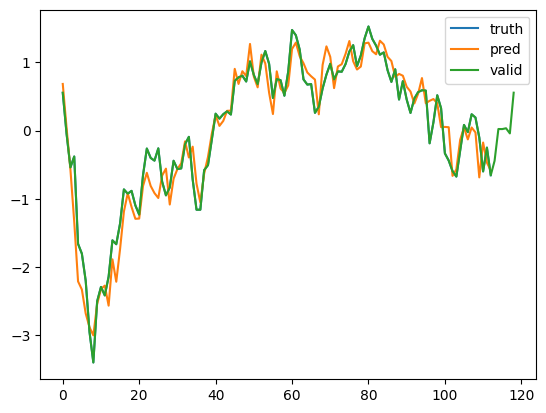

In [16]:
plt.plot(ac_val, label = "truth")
plt.plot(pred_val, label= "pred")
plt.plot(np.array(ts_valid)[0], label = "valid")
plt.legend()
plt.plot()

array([-1.55057648, -1.53999143, -1.58270666,  1.36153525,  1.44171406,
        1.00799992,  1.21593673,  0.90425334,  1.08157222,  1.01064306,
        1.51374296,  1.38774616,  0.99786833,  0.71261903,  0.28242997,
        0.38265146,  0.38265146,  0.36855382,  0.34212243, -0.21604243,
       -0.67024023, -0.52133711, -0.52133711, -0.52133711, -0.52133711,
       -0.52133711, -1.70573237, -1.83855616, -2.20508671, -2.90026056,
       -3.31304738, -2.48372816, -2.28944936, -2.40465178, -2.14979858,
       -1.65793538, -1.71057767, -1.42907394, -0.96760549, -1.02597773,
       -0.98743038, -1.18435366, -1.30968632, -0.77575069, -0.41362448,
       -0.54094151, -0.57772766, -0.41120183, -0.86165674, -1.04844575,
       -0.9411741 , -0.57948886, -0.69226728, -0.68301764, -0.35503445,
       -0.25547172, -0.83500218, -1.24272321, -1.24294369, -0.70724686,
       -0.63896353, -0.29446004,  0.05841384, -0.00898756,  0.05136636,
        0.09035468,  0.04673885,  0.50402076,  0.55071801,  0.57

In [114]:
np.array(ts_valid)[0]

array([ 1.36153525,  1.44171406,  1.00799992,  1.21593673,  0.90425334,
        1.08157222,  1.01064306,  1.51374296,  1.38774616,  0.99786833,
        0.71261903,  0.28242997,  0.38265146,  0.38265146,  0.36855382,
        0.34212243, -0.21604243, -0.67024023, -0.52133711, -0.52133711,
       -0.52133711, -0.52133711, -0.52133711, -1.70573237, -1.83855616,
       -2.20508671, -2.90026056, -3.31304738, -2.48372816, -2.28944936,
       -2.40465178, -2.14979858, -1.65793538, -1.71057767, -1.42907394,
       -0.96760549, -1.02597773, -0.98743038, -1.18435366, -1.30968632,
       -0.77575069, -0.41362448, -0.54094151, -0.57772766, -0.41120183,
       -0.86165674, -1.04844575, -0.9411741 , -0.57948886, -0.69226728,
       -0.68301764, -0.35503445, -0.25547172, -0.83500218, -1.24272321,
       -1.24294369, -0.70724686, -0.63896353, -0.29446004,  0.05841384,
       -0.00898756,  0.05136636,  0.09035468,  0.04673885,  0.50402076,
        0.55071801,  0.57340652,  0.49433014,  0.76768667,  0.58

<function matplotlib.pyplot.show(close=None, block=None)>

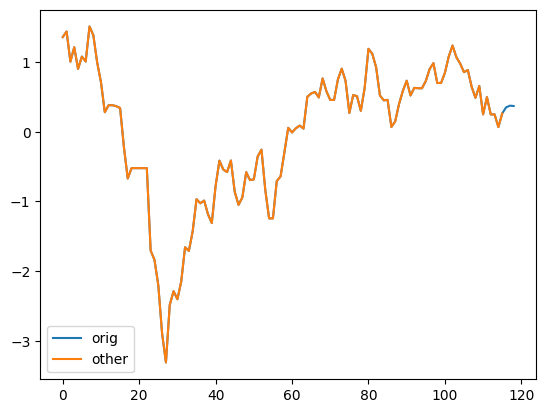

In [118]:
plt.plot(ts_valid[0],label="orig")
plt.plot(ac_val[3:], label="other")
plt.legend()
plt.show

In [97]:
row = comb[-1]
print(row)
ac_val.append(row[0])
parameters = ART.predict(tree, row[1:])
print(parameters)
pred_val.append((np.dot(row[1:][:,np.newaxis].T,parameters[1]) + parameters[2])[0])
print(pred_val[-1])

[ 1.28062528  1.58869854  1.5998103  -0.64673028 -0.50287334 -0.59285627
  0.24367495  0.30559974  0.28375488]
(array([0.0182294]), array([ 0.96260134, -0.21612036,  0.04919698, -0.29303609,  0.27733079,
        0.53019782, -0.56934173,  0.24058753]), [0.14810395914293661])
1.3062344210340964


In [98]:
row = test[10]
print(row)
ac_val.append(row[0])
parameters = ART.predict(tree, row[1:])
print(parameters)
pred_val.append((np.dot(row[1:][:,np.newaxis].T,parameters[1]) + parameters[2])[0])
print(pred_val[-1])

[-2.48257179 -2.05308333 -1.76767143 -1.43115775 -1.19995698 -1.12260903
 -1.85120362 -1.8076431  -1.4652621 ]
(array([0.00478942]), array([ 0.73907368, -0.59957796,  0.18276266,  0.06271892,  0.07774978,
        0.69179181, -0.68899628,  0.37685209]), [-0.4071049230522567])
-1.8761079748002045


In [71]:
print(pred_val)
print(ac_val)

[1.8281717705287075, 1.639601566465472, 2.5874406743018787, 0.7974597534438609, 1.0159672805080595, 0.16838335205688632, 0.48016994703110005, 0.01634670534987709, -0.34872708579932343, -0.6514078673459349, -1.1775728850299796, -1.10354730190167, -1.20470720825096, -1.52011798864096, -0.9063126628641007, -0.4362904160755509, -1.1772973637794442, 0.3089086940563854, -0.8132646186144903, -0.5446718843826026, 0.17824199360586923, -0.10966538389845927, -0.2702286124146806, -0.4481875190754541, 0.4183152825038227, 0.02523794827404084, 0.2498437701709412, 0.41325493495921684, 0.41835084959789515, 0.8313723274350313, 0.8583137883961351, 1.1185594016159466, 0.1962415869308171, 0.9011744991064843, 1.5550441368845673, 2.0457409831706856, 1.9639642740474132, 1.2682365215856422, 0.8825651984906098]
[1.5886985429521023, 1.5998102975602164, 1.234872403757687, -0.04578307829518113, 0.4885279804118064, -0.11527183858731892, -0.7394821837991487, -0.3398307578817322, -1.2054833949748167, -1.3154098214286